In [35]:
import numpy as np
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.lines as mlines
import cartopy
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature
import geopandas
from skimage.measure import block_reduce
from shapely.geometry import Point, shape
from scipy.interpolate import interp2d
import fiona
import shapely.geometry as sgeom
import shapely.vectorized as v
from shapely.prepared import prep
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import gaussian_filter as gf
from datetime import datetime as dt, timedelta as td
import datetime
import pandas as pd
from scipy.stats import linregress

In [36]:
geoms = fiona.open(shapereader.natural_earth(resolution='50m', category='physical', name='land'))
land_geom = [shape(geom['geometry']) for geom in geoms]
land = prep(land_geom)

In [37]:
df = geopandas.read_file("../other-files/ne_10m_admin_0_countries_ind.shp")
poly = df.loc[df['ADMIN'] == 'India']['geometry'].values[0]

In [38]:
dateparse = lambda x: dt.strptime(x, '%d-%b-%y')


wind_actual = pd.read_csv("../../capacity/data/wind-actual.dat", sep="\t", parse_dates=['Date'], date_parser=dateparse)
solar_actual = pd.read_csv("../../capacity/data/solar-actual.dat", sep="\t", parse_dates=['Date'], date_parser=dateparse)
hydro_actual = pd.read_csv("../../capacity/data/hydro-actual.dat", sep="\t", parse_dates=['Date'], date_parser=dateparse)


/tmp/ipykernel_3729/1046245490.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  wind_actual = pd.read_csv("../../capacity/data/wind-actual.dat", sep="\t", parse_dates=['Date'], date_parser=dateparse)
/tmp/ipykernel_3729/1046245490.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  solar_actual = pd.read_csv("../../capacity/data/solar-actual.dat", sep="\t", parse_dates=['Date'], date_parser=dateparse)
/tmp/ipykernel_3729/1046245490.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  hydro_actual = pd.read_csv("../../capacity/d

In [39]:
%matplotlib inline
plt.ioff()

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10,10))
ax1, ax2, ax3 = axes

In [40]:
color_keys = {'NER':'lightgray','ER':'moccasin','SR':'skyblue','WR':'pink','NR':'lightgreen', 'I':'w'}

C = 1/24

for ax, df in zip(axes, [wind_actual, solar_actual, hydro_actual]):	
	n, e, s, w, ne  = df['NR']*C, df['ER']*C, df['SR']*C, df['WR']*C, df['NER']*C
	ax.stackplot(df['Date'], ne, e, s, w, n, colors=[color_keys[i] for i in ['NER', 'ER', 'SR', 'WR', 'NR']])
	ax.plot(df['Date'], df['Total']*C, 'k-', label='Total', zorder=10, lw=.5)
	ax.set_xlim([dt(2020,1,1), dt(2022,9,30)])

In [41]:
wind_capacity_factor = np.load("../../capacity/data/full_arrays/windcapacity-since2020.npy")[...,::-1,:]
solar_capacity_factor = np.load("../../capacity/data/full_arrays/solarcapacity-since2020.npy")[...,::-1,:]
solar_capacity_factor[solar_capacity_factor<0] = np.nan

In [42]:
xmin, xmax = 65, 100
ymin, ymax = 5, 40

lons = np.linspace(xmin,xmax,wind_capacity_factor.shape[-1])
lats = np.linspace(ymin,ymax,wind_capacity_factor.shape[-2])

In [43]:

solar = block_reduce(solar_capacity_factor, block_size = (1,4,4), func=np.mean)[:,:-1,:-1]
wind = block_reduce(wind_capacity_factor, block_size = (1,4,4), func=np.mean)[:,:-1,:-1]


new_lons = block_reduce(lons, block_size=(4,), func=np.mean)[:-1]
new_lats = block_reduce(lats, block_size=(4,), func=np.mean)[:-1]


dx = 1
gridx = np.arange(60,100,dx)
gridy = np.arange(5,40,dx)


In [44]:
kw_arr = np.load("../../kruitwagen/gridded-capacity.npy")
cea_solar_arr = np.load("../../cea-data/gridded-solar-cap.npy")

cea_wind_arr = np.load("../../cea-data/gridded-wind-cap.npy")
twp_arr = np.load("../../cea-data/gridded-twp-cap.npy")

solar_installed = 0.5*(kw_arr+cea_solar_arr)
wind_installed = 0.5*(twp_arr+cea_wind_arr)


solar_installed = interp2d(gridx, gridy, solar_installed)(new_lons, new_lats)
wind_installed = interp2d(gridx, gridy, wind_installed)(new_lons, new_lats)

/tmp/ipykernel_3729/2359238077.py:11: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  solar_installed = interp2d(gridx, gridy, solar_installed)(new_lons, new_lats)
/tmp/ipykernel_3729/2359238077.py:12: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefe

In [45]:
mask = np.zeros_like(solar_installed)

for i, x in enumerate(new_lons):
	for j, y in enumerate(new_lats):
		p = Point(x,y)		
		if poly.contains(p):
			mask[j,i]=1

solar_installed *=mask

solar_installed/=solar_installed.sum()
wind_installed/=wind_installed.sum()

solar_produced = solar*solar_installed[None, :, :] 
wind_produced = wind*wind_installed[None, :, :]

solar_total = np.sum(solar_produced, axis=(-1,-2))
wind_total = np.sum(wind_produced, axis=(-1,-2))

In [46]:
dates = np.array([dt(2020,1,1)+td(days=i) for i in range(len(wind_capacity_factor))])
dates_ts = np.array([(d-dt(1970,1,1)).total_seconds() for d in dates])


df = pd.read_csv("../../capacity/data/tabulated-installed-by-date.csv")
installed_dates = np.array([dt.strptime(t,"%d-%b-%y") for t in df['Date'].values])
installed_dates_ts = np.array([(d-dt(1970,1,1)).total_seconds() for d in installed_dates])


solar_actual_installed = interp1d(installed_dates_ts, df['Solar']/1000)(dates_ts)
wind_actual_installed = interp1d(installed_dates_ts, df['Wind']/1000)(dates_ts)

wind_total*=wind_actual_installed
solar_total*=solar_actual_installed

In [47]:
axes[0].plot(dates, wind_total, color='tab:blue', lw=2)
axes[1].plot(dates, solar_total*(1-0.128), color='tab:blue', lw=2)

sdates = list(map(dt.utcfromtimestamp, solar_actual['Date'].values.astype(np.uint64) / 1e9))
wdates = list(map(dt.utcfromtimestamp, wind_actual['Date'].values.astype(np.uint64) / 1e9))

it = np.in1d(sdates, dates)
n = ~np.isnan(solar_total)
print(linregress(solar_total[n], solar_actual['Total'].values[it][n]))

it = np.in1d(wdates, dates)
n = ~np.isnan(wind_total)
print(linregress(wind_total[n], wind_actual['Total'].values[it][n]))

LinregressResult(slope=17.795576343141434, intercept=36.396152344490474, rvalue=0.9220861658735633, pvalue=0.0, stderr=0.23237216569150204, intercept_stderr=2.03130273157063)
LinregressResult(slope=26.460241005901143, intercept=12.888590788746853, rvalue=0.9510232487564261, pvalue=0.0, stderr=0.27170336061970723, intercept_stderr=1.9992952559527435)


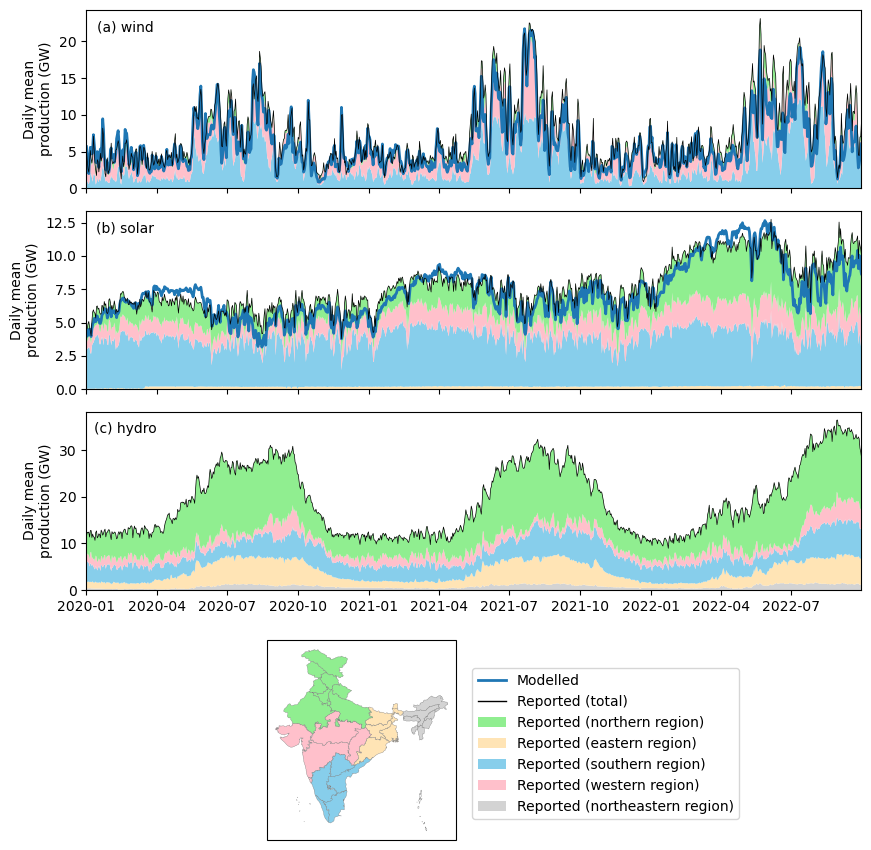

In [48]:
for ax in axes:
	ax.set_ylim(bottom=0)
	ax.set_ylabel("Daily mean\nproduction (GW)")

ax1.text(0.05, 0.9, "(a) wind", ha='center', va='center', transform=ax1.transAxes)
ax2.text(0.05, 0.9, "(b) solar", ha='center', va='center', transform=ax2.transAxes)
ax3.text(0.05, 0.9, "(c) hydro", ha='center', va='center', transform=ax3.transAxes)

fig.subplots_adjust(bottom=.3, hspace=.125)

handles = []
handles.append(mlines.Line2D([], [], color='tab:blue', lw=2, label='Modelled'))
handles.append(mlines.Line2D([], [], color='k', lw=1, label='Reported (total)'))
handles.append(plt.Rectangle((0,0),1,1, fc= color_keys['NR'], label='Reported (northern region)'))
handles.append(plt.Rectangle((0,0),1,1, fc= color_keys['ER'], label='Reported (eastern region)'))
handles.append(plt.Rectangle((0,0),1,1, fc= color_keys['SR'], label='Reported (southern region)'))
handles.append(plt.Rectangle((0,0),1,1, fc= color_keys['WR'], label='Reported (western region)'))
handles.append(plt.Rectangle((0,0),1,1, fc= color_keys['NER'], label='Reported (northeastern region)'))

ax3.legend(handles = handles, loc='upper center', bbox_to_anchor=(0.67, -0.4))




ax4 = plt.axes([0.3,0.05,0.2,0.2], projection=cartopy.crs.PlateCarree())
states_df = geopandas.read_file("/home/users/kieran/geodata/india_states_lores.zip").drop_duplicates()

regions = {'Assam': 'NER',
		   'Dadara & Nagar Havelli': 'WR', 
		   'Maharashtra': 'WR', 
		   'Madhya Pradesh': 'WR', 
		   'Arunachal Pradesh': 'NER', 
		   'Bihar': 'ER', 
		   'Tripura': 'NER', 
		   'Lakshadweep': 'I', 
		   'Haryana': 'NR', 
		   'Daman & Diu': 'WR', 
		   'NCT of Delhi': 'NR', 
		   'Meghalaya': 'NER', 
		   'Andhra Pradesh': 'SR', 
		   'Sikkim': 'ER', 
		   'Manipur': 'NER', 
		   'Rajasthan': 'NR', 
		   'Kerala': 'SR', 
		   'Nagaland': 'NER', 
		   'Jammu & Kashmir': 'NR', 
		   'Jharkhand': 'ER', 
		   'Tamil Nadu': 'SR', 
		   'Gujarat': 'WR', 
		   'Uttar Pradesh': 'NR', 
		   'Karnataka': 'SR', 
		   'Ladakh': 'NR', 
		   'Mizoram': 'NER', 
		   'Andaman & Nicobar Island': 'I', 
		   'Goa': 'WR', 
		   'Himachal Pradesh': 'NR', 
		   'West Bengal': 'ER', 
		   'Telangana': 'SR', 
		   'Chandigarh' : 'NR', 
		   'Uttarakhand': 'NR', 
		   'Chhattisgarh': 'WR', 
		   'Odisha': 'ER', 
		   'Punjab': 'NR', 
		   'Puducherry': 'SR'}



for state in regions:
	gf = states_df[states_df.ST_NM==state]
	gf.plot(ax=ax4, color=color_keys[regions[state]], edgecolor='grey', linewidth=0.25)



plt.show()
